In [1]:
> library("ggplot2")


ERROR: Error in parse(text = x, srcfile = src): <text>:1:1: unexpected '>'
1: >
    ^


In [2]:
> library("ggplot2")

ERROR: Error in parse(text = x, srcfile = src): <text>:1:1: unexpected '>'
1: >
    ^


In [3]:
library("ggplot2")


ERROR: Error in library("ggplot2"): there is no package called 'ggplot2'


In [9]:
library(ggplot2)
library(dplyr)

library(caret)      # machine learning and pre processing functions
library(gridExtra)  # combo plot for ggplot functions


In [14]:
load("/Users/cghdhv/Downloads/movies.Rdata")
set.seed(123)


Exploratory data analysis
First step before actually making the first viewings and processings over the data,
we split our dataset in training and test data. Most of the algorithms that learn with data with the objetive to predict new incomes 
try to minimize the error they make with the first step (learning).
Because of this, if we evaluate our data over the error the algorithm(regression in this case) makes with the training data,
we would be making an over optimistic assumption.
So the objetive of the test set is to give our algorithm new data and thus make a more real error estimate of our modelling 
process.



In [17]:
# sample testing data
testingIndex <- sample(nrow(movies),floor(nrow(movies) * 0.2),replace = FALSE)
# get test and training data
testing  <- movies[testingIndex,]
training <- movies[-testingIndex,]

# response variables of interest:
# imdb_rating, critics_rating, critics_score, audience_rating, audience_score
# remove response cols, title, studio, actors and url's columns
responseCols <- c(13,15,16,17,18)
noInterestVars <- c(1,6,25:32)

trainingPredictors <- training[,-c(responseCols,noInterestVars)]
trainingResponse   <- training[, responseCols]

testingPredictors <- testing[,-c(responseCols,noInterestVars)]
testingResponse   <- testing[, responseCols]


Data Imputation
But, before starting with our analytical thinking, we must evaluate and act against missing values as linear models are no robust against it. We can deal with NA’s with a few approaches and I evaluated 3 of them:

Row removal: Remove the lines that have at least one NA

Column Removal: Remove columns if they have more NA’s than data

Imputation: Use an algorithmic approach to estimate the missing values. We can make this approach using a few techniques, such as median imputation, knn or bagged tree imputation. I have tested the three proposed methods here. In order not to make this report too long, I evaluated and tested these approaches with this project final model and the Median Imputation was the best one, i.e. the smallest RMSE.


In [18]:
# model 1: remove rows with NA?
anyNA <- function(row){ any(is.na(row))}          # function to return which row has at least a NA

rowsWithNA <- apply(training, 1, anyNA)           # apply the function to each row

rowsWithNAIndexTRUE <- which(rowsWithNA == TRUE)  # get which row return TRUE
length(rowsWithNAIndexTRUE)/nrow(training)        # few rows with NA's, might be a good way of removing NA


[1] 0.05566219

In [19]:
# In this report we will NOT use this model, as I have already compared it with the Median imputation model
naRMTrainingData <- training[-rowsWithNAIndexTRUE,] # create new model with the NA rows removed
############################################################################################################
# Model 2: remove columns that have a lot of NA's?

# function to return which row has at least a NA
colsWithNA <- apply(trainingPredictors, 2, function(col) { any(is.na(col))}) #

colsWithNAIndexTRUE <- which(colsWithNA == TRUE) # get cols index that have at least one NA

# low percentage of NA's. No need to exclude columns, take other actions to imput then
apply(trainingPredictors[,colsWithNAIndexTRUE], 2, function(cols) {sum(is.na(cols))/length(cols)})


runtime  dvd_rel_year dvd_rel_month   dvd_rel_day 
  0.001919386   0.015355086   0.015355086   0.015355086

In [20]:
# model 3, 4 and 5: IMPUTATIONS
#kNNImput <- preProcess(training, method='knnImpute')
#bagImput <- preProcess(training, method='bagImpute', na.remove = TRUE)
medianImput <- preProcess(training, method='medianImpute')

#knnImputTrainingData <- predict(kNNImput, training)
#bagImputTrainingData <- predict(bagImput, training)
medianImputTrainingData <- predict(medianImput, training)
# Already tested these models with the final model, and the best model was the Median Imputation


In [21]:
medianImputTrainingPredictors <- medianImputTrainingData[,-c(responseCols,noInterestVars)]
medianImputTrainingPredictors <- cbind(medianImputTrainingPredictors,medianImputTrainingData[,responseCols[1]])

### first raw model with what we got
model.raw <- lm(imdb_rating ~ .,
                data = medianImputTrainingPredictors)
summary(model.raw)



Call:
lm(formula = imdb_rating ~ ., data = medianImputTrainingPredictors)

Residuals:
    Min      1Q  Median      3Q     Max 
-3.8163 -0.4056  0.0620  0.5602  2.1768 

Coefficients:
                                 Estimate Std. Error t value Pr(>|t|)    
(Intercept)                     5.294e+01  1.810e+01   2.925 0.003608 ** 
title_typeFeature Film         -8.687e-01  3.295e-01  -2.636 0.008650 ** 
title_typeTV Movie             -8.232e-01  5.421e-01  -1.519 0.129506    
genreAnimation                 -3.952e-01  3.837e-01  -1.030 0.303568    
genreArt House & International  7.212e-01  2.675e-01   2.697 0.007246 ** 
genreComedy                    -1.063e-01  1.614e-01  -0.659 0.510205    
genreDocumentary                8.754e-01  3.598e-01   2.433 0.015337 *  
genreDrama                      5.824e-01  1.386e-01   4.203 3.13e-05 ***
genreHorror                    -1.492e-01  2.581e-01  -0.578 0.563470    
genreMusical & Performing Arts  1.186e+00  3.286e-01   3.610 0.000338 ***
ge

With this first attempt, we see that our model does a relative poor fit, with a R2 score of just 42%, and a adjusted R2 of 38%.

Near Zero Variance - NZV and Correlated Columns Verification
Non informative predictors and Multicollinearity are a few problems that can make or model worse or unstable (not relevant predictors, therefore, not generalizable for new data and predictions).

NZV variables are columns that have little variation among its values, i.e., there is one predominant value, making the values almost constant between the data examples, providing little discriminative power. There are discussions if we should remove the nzv predictors, considering that we are throwing out information but, as we are trying to get the most informative model to our data, we would stick with this approach to remove them. However, as it is going to be shown next,, maybe these rows with the rare column values could mean something special.

As for multicollinearity, we will analyze among the predictors if we can find a big correlation between then. Correlated predictors are known to destabilize the model parameters, increase the prediction standard error and worse the fit to new data. Let see how our data is organized. We will use the Caret package to extract the nzv variables and the cor command to extract the correlation matrix:



In [23]:
nzv <- nearZeroVar(training, saveMetrics= TRUE) 
nzvIndices <- which(nzv$nzv == TRUE)
nzv[nzvIndices, ]


,freqRatio,percentUnique,zeroVar,nzv
best_pic_nom,25.05000,0.3838772,FALSE,TRUE
best_pic_win,85.83333,0.3838772,FALSE,TRUE
top200_box,51.10000,0.3838772,FALSE,TRUE


As we can see {best_pic_nom, best_pic_win, top200_box} were selected as no discriminative variables. Probably, if a movie is nominated to or wins an oscar or it is in the Top 200 Box Office, it has a bigger chance to receive higher scores. In the plots below, we analyzed the nzv variables distributions, viewing whether a movie is premiated or not and its possible correspondent scores, such as imdb_rating, critics_rating and critics_score. As we have seen, there is an imbalance in the nzv columns, but they might provide a great discrimination power over the imdb_rating, our response variable of interest in this report. Therefore, we will not remove the nzv variables.



Distribution of: best_pic_nom
 no yes 
629  22 

Distribution of: best_pic_win
 no yes 
644   7 


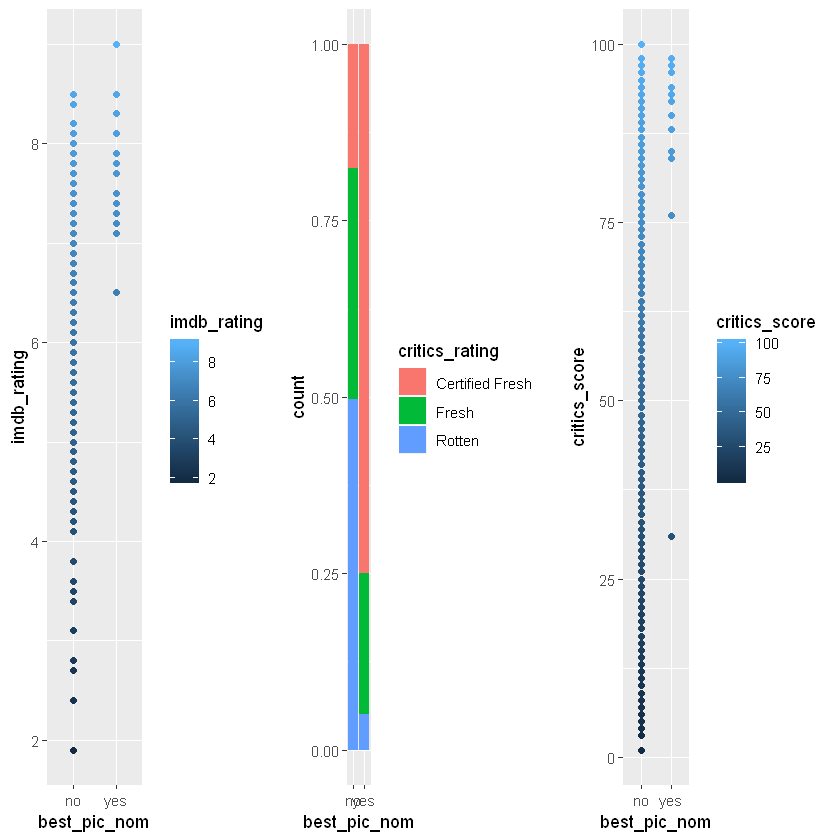


Distribution of: top200_box
 no yes 
636  15 


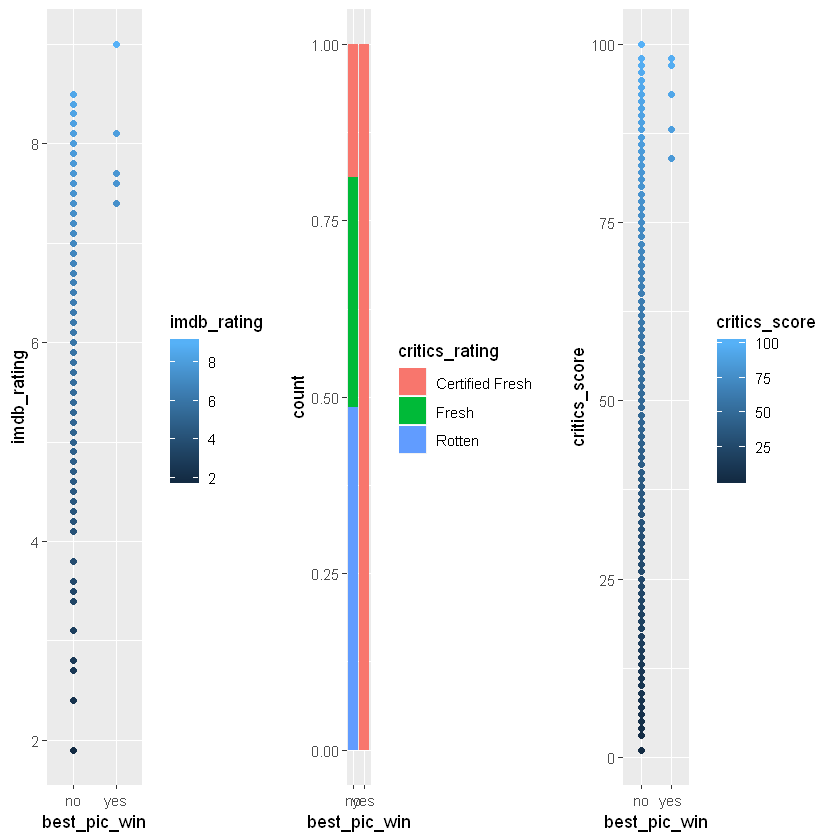

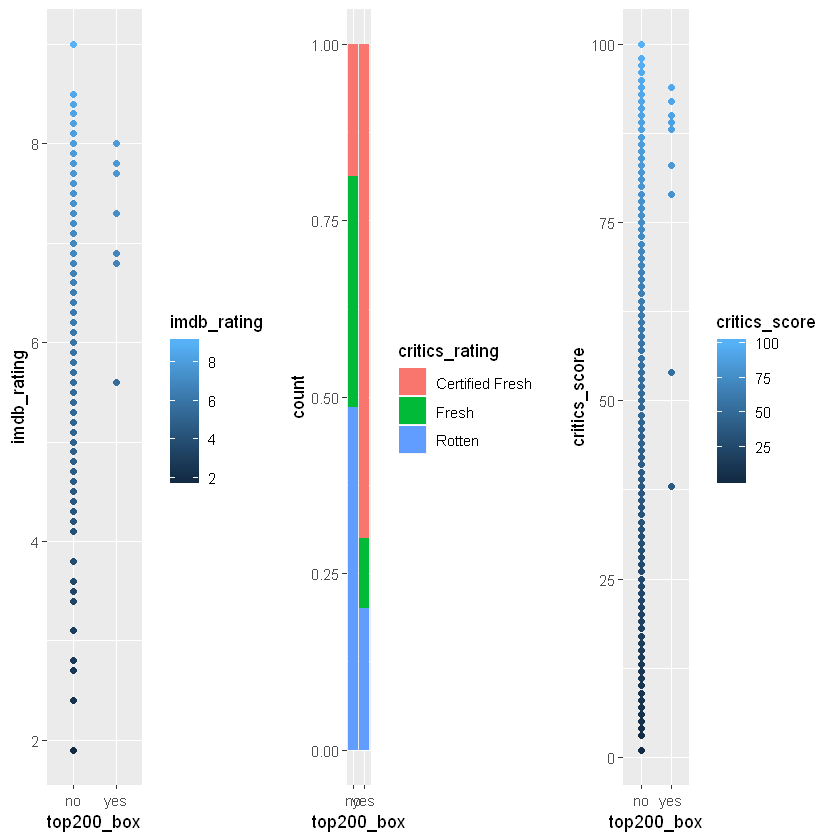

In [24]:
for(i in 1:3){
  cat('Distribution of:', names(training)[nzvIndices[i]])
  print(table(movies[,nzvIndices[i]]))
  plot1 <- ggplot(training, aes_string(x = names(training)[nzvIndices[i]], y = names(training)[responseCols[1]], colour = names(training)[responseCols[1]])) + geom_point()
  plot2 <- ggplot(training, aes_string(x = names(training)[nzvIndices[i]], fill = names(training)[responseCols[2]])) + geom_bar(position = 'fill')
  plot3 <- ggplot(training, aes_string(x = names(training)[nzvIndices[i]], y = names(training)[responseCols[3]], colour = names(training)[responseCols[3]])) + geom_point()
  grid.arrange(plot1, plot2, plot3, ncol=3)
  cat('\n')
}


Next, we evaluate the columns correlation. As we perform the traditional Pearson Numerical Correlation, first we removed the factor variables. For a mixed correlation status, between numerical and factor variables, we could have used the Heterogeneous Correlation Matrix or the Point-Biserial Correlation, but as these are more advanced techniques, we will not consider it in our analysis. Inspecting our correlation matrix, we see that the most correlated columns are between the response columns, not of interest in our research. Therefore, in spite of our predictor variables, we will not remove them to decrease multicollinearity.



In [25]:
numericIndices <- sapply(medianImputTrainingData, is.numeric) # extract which columns are numeric
colsCorr <- cor(medianImputTrainingData[,numericIndices])     # filter out non numeric columns
colsCorr                                                      # evaluate results


,runtime,thtr_rel_year,thtr_rel_month,thtr_rel_day,dvd_rel_year,dvd_rel_month,dvd_rel_day,imdb_rating,imdb_num_votes,critics_score,audience_score
runtime,1.00000000,-0.120204389,0.22362935,0.014051800,-0.085817165,-0.034356922,0.014415410,0.238138830,0.33088145,0.149462454,0.133528859
thtr_rel_year,-0.12020439,1.000000000,-0.01227360,0.101436328,0.660003094,0.039313687,-0.008207814,-0.024295900,0.15457969,-0.076656167,-0.032735466
thtr_rel_month,0.22362935,-0.012273599,1.00000000,0.139499582,-0.017759063,-0.144679718,0.025209517,0.096163040,0.12418133,0.071177399,0.055779316
thtr_rel_day,0.01405180,0.101436328,0.13949958,1.000000000,0.046170524,-0.003061158,-0.024675264,0.019718932,0.06293989,0.037242883,0.019707765
dvd_rel_year,-0.08581717,0.660003094,-0.01775906,0.046170524,1.000000000,-0.022568610,-0.072749387,-0.002343631,0.11614256,0.013083532,-0.046066449
dvd_rel_month,-0.03435692,0.039313687,-0.14467972,-0.003061158,-0.022568610,1.000000000,-0.020638191,0.044909505,0.04880466,-0.004015632,0.056367253
dvd_rel_day,0.01441541,-0.008207814,0.02520952,-0.024675264,-0.072749387,-0.020638191,1.000000000,-0.001373309,-0.01571554,-0.025710075,0.005615385
imdb_rating,0.23813883,-0.024295900,0.09616304,0.019718932,-0.002343631,0.044909505,-0.001373309,1.000000000,0.32017885,0.766421702,0.862934330
imdb_num_votes,0.33088145,0.154579688,0.12418133,0.062939890,0.116142562,0.048804663,-0.015715537,0.320178847,1.00000000,0.201405490,0.272805236
critics_score,0.14946245,-0.076656167,0.07117740,0.037242883,0.013083532,-0.004015632,-0.025710075,0.766421702,0.20140549,1.000000000,0.699331168


Feature Engineering and Modeling
Feature engineering is a non standard field of data modelling / machine learning that tries to transform raw data into features that better represent the underlying problem to the predictive models, resulting in improved model accuracy on unseen data. In this section, I present the insights that I have made to get to the final model. The movies training dataset was repeatedly sampled and transformed in order to get a high adjusted R2 score. The list below shows the feature engineering process taken to get to the final model and their respective R2 scores. I will explain each item and why I have included them in the final model. For each model created, the residuals and predicted values plot was analyzed, using the code below.


In [31]:
# recurrent evaluation using this section

                  # predicted values for the training dataset
#testePredict <- predict(final.model,medianImputTrainingPredictors)
                  # plot expected versus predicted values
#plot(abs(medianImputTrainingPredictors$imdb_rating - testePredict))
                  # plot attributes distribution versus predicted values
#for(i in 1:ncol(medianImputTrainingPredictors))
#{
 # title <- sprintf('%s', names(medianImputTrainingPredictors)[i])
 # plot(medianImputTrainingPredictors[,i],medianImputTrainingPredictors$imdb_rating,main = #title)
#
#}


1 - Pure Model: The raw model built Previously

2 - Transformation of imdb_ratings < 5 to 5: As we are trying to predict the best ratings, I removed the low score ratings and merged then into the 5 score. In this way, maybe we would reduce the noise and force the model to focus to predict the different scores > 5.

3 - Theatre release year bin transformation: Another feature transformation to try to reduce the variance of the model. Firstly, grouping the years in bins created just 5 years categories, instead of more than 40 years of variations and, besides that, looking at the histogram of the release year attribute, we noticed that people is not used to rating a movie with a bad score, they usually rate a movie if there is a positive impression about it. Secondly, the idea is that maybe the impact of year in the final imdb ratings were not granulated as individual years, but in a range of years.

4 - Weights to award wining/nominated movies: As we have verified in the NZV variables, the nominated people indicator for best actor / actress / director showed a high discrimination capacity. But we have also seen that the number of examples with nominated celebrities was really small. This sounded like a class imbalance problem, where the model just learned to ignore this examples and tended to use the majority of the other values, i.e. no people nominate. To force the model to pay a higher attention to these minor examples, we altered our linear model to a weighted linear regression, where we add a weight term to the classic least squares algorithm:

5 - Best Actress factor removal and horror movie category removed: After ploting the best_actress_win versus the predicted imdb_rating, We saw that there was no significant difference between the predicted imbd_ratings for a movie with a best actress prize winner and a no winner. Besides, We also realized that the horror movie genre could not bring a better prediction power, and removing it increased the adjusted R2 score.

6 - Interaction terms between release year and movie genre, best actor, actress and director: This interaction between factor variables worked as an increase in the β0 bias parameter. My thought was that maybe people used to rate old (i.e. ‘classic’, ‘old-school’, etc…) movies with a better spirit than when with new blockbuster movies. This was a gut feeling, there was no graphical or statistical evidence for the variables interaction but the feeling that people like to feel cult. This step generated a lot of parameters, but they also provided good useful information also, because the adjusted R2 followed the general R2 closely.

7 - Inclusion of the 5 biggest studios: At the beggining of the project, I did not include the studios variable, because there was too much variability (an unique variable factor of 90%, meaning that 90% of the total studios values were unique). But maybe, movies coming from the biggests (and more famous) studios could bring some more clues about its ratings. So I selected the 5 more frequent studios in the training dataset and transformed the other studios to a new category, ‘other’. The new added variable was a factor with 6 levels, the 5 biggest studios and the ‘other’ category.

8 - Removal of the best actress weights: This process followed step 5, as I had forgotten to remove the weights of the best_actress_win variable. They were not even being included in the model, so there was no sense in maintain big importance weights for the movies coming with an award wining actress.

All the feature engineer steps presented above are coded below and, finally, the final model is presented. As we would use the same steps for the training and testing dataset, We created a function that took a dataframe plus the function mode (training or testing) and it returned the processed dataframe. Besides the feature engineer process, we also transformed two significant parameters from the first model. “runtime” and “imdb_num_votes” were really significant predictors, but their parameter value were really small (runtime = 5.923e-03 and imdb_num_votes), so We transformed then to a bigger scale (runtime in hours and imdb_num_votes x 1000). In this way, our parameters would be on a scale easier to understand.

In [32]:
moviesVarEngineer <- function(dataFrame, mode){
  
  ######### feature transformation 
  dataFrame$imdb_num_votes <- dataFrame$imdb_num_votes/1000
  dataFrame$runtime <- dataFrame$runtime/60
  ######### 
  
  # step 2
  dataFrame$imdb_rating[dataFrame$imdb_rating < 5] <- 5
  
  # step 3
  dataFrame$thtr_rel_year_BIN <- cut(dataFrame$thtr_rel_year, breaks = c(1969, 1980, 1990,2000,2010, 2014))
  dataFrame$thtr_rel_year <- NULL
  
  # step 4 = weights - outside of the function
  
  # step 5 = best actress removal and horror genre category removal
  dataFrame$genre[dataFrame$genre == 'Horror'] <- 'Other'
  dataFrame$genre <- factor(dataFrame$genre, levels = levels(dataFrame$genre)[c(1:6,8:11)])
  
  # step 6 = added interactions in the final model
  
  # step 7 = selected the 5 biggest studios and transformed the others to 'other'
  studios <- c('Paramount Pictures','Warner Bros. Pictures','Sony Pictures Home Entertainment','Universal Pictures','Warner Home Video')
  if(mode == 'training'){
    dataFrame$studio <- training$studio  
  }else{
    dataFrame$studio <- testing$studio
  }
  dataFrame$studio[!dataFrame$studio %in% studios] <- NA
  dataFrame$studio <- factor(dataFrame$studio, levels = c(studios,'Other'))
  dataFrame$studio[is.na(dataFrame$studio)] <- 'Other'
  
  invisible(dataFrame)
}


In [33]:
medianImputTrainingPredictors <- moviesVarEngineer(medianImputTrainingPredictors,'training')

weight <- rep(NA,nrow(medianImputTrainingPredictors))
weight[medianImputTrainingPredictors$best_pic_nom == 'yes'] <- 1000
weight[medianImputTrainingPredictors$best_pic_win == 'yes'] <- 1000
weight[medianImputTrainingPredictors$best_dir_win == 'yes'] <- 1000
weight[is.na(weight)] <- 1

final.model <- lm(imdb_rating ~ title_type + genre + runtime + 
              mpaa_rating  + imdb_num_votes + 
              best_pic_nom + thtr_rel_year_BIN + best_pic_win + 
              best_dir_win + studio + genre:thtr_rel_year_BIN +
              thtr_rel_year_BIN:best_pic_win + thtr_rel_year_BIN:best_actress_win +
              thtr_rel_year_BIN:best_dir_win,
                data = medianImputTrainingPredictors,
                weights = weight)
summary(final.model)



Call:
lm(formula = imdb_rating ~ title_type + genre + runtime + mpaa_rating + 
    imdb_num_votes + best_pic_nom + thtr_rel_year_BIN + best_pic_win + 
    best_dir_win + studio + genre:thtr_rel_year_BIN + thtr_rel_year_BIN:best_pic_win + 
    thtr_rel_year_BIN:best_actress_win + thtr_rel_year_BIN:best_dir_win, 
    data = medianImputTrainingPredictors, weights = weight)

Weighted Residuals:
    Min      1Q  Median      3Q     Max 
-44.713  -0.880  -0.246   0.329  34.204 

Coefficients: (7 not defined because of singularities)
                                                              Estimate
(Intercept)                                                  5.6210711
title_typeFeature Film                                      -0.7739097
title_typeTV Movie                                          -0.8516369
genreAnimation                                              -0.6769346
genreArt House & International                               1.7014661
genreComedy                              

Part 5: Model Interpretation
Firstly, we identify a few NA’s in the model. That happened because there was no examples in the training set the agreed with the two factor variables, e.g. there was no animation movie released between years 1980 and 1990 in the dataset.

We took a look at the statistical significant parameter estimation.
All the following results can be interpreted as the correlation of each paramenter with the imdb_rating response variable, when all the other attributes remain constant. Most of the attributes were positive correlated with the response variable.

The base factor predictor for the genre attribute was action & adventure Starting from there, we can see that drama movies tend to get higher ratings, on average of 1.47 points more, and even higher scores for drama movies between (2000,2010)]. However, as the same drama genre is not so high for movies released between (1980,1990].

The runtime attribute (in hours) got a positive correlation with the imdb_rating. In theory, each additional hour to the movie, we could, on average get a increase of 0.69 rating points. We have to be careful with this case, in the sense that we can not extra extrapolate the fit, looking at the Interquartile Range - IQR for the runtime variable, we see that the core values, the 25% and 75% quartiles are in a interval of just 0.383 points apart. So we can not extrapolate too much on the number of hours, i.e. we can not predict the average imdb_ratings for a 13 hours movie, expecting an incredible high score.



In [34]:
IQR(medianImputTrainingPredictors$runtime)


[1] 0.3666667

One theory that might make sense in a video popularity is that, the more upvotes a movie receives, the more popular it becomes, more people will want to watch it because it is popular and more upvotes it will receive. This redundant path can be represented in the model above with the imdb_num_votes parameter estimation. For its value, each one thousand votes at IMDB, can make the movie ratings increase more 0.002 points. Considering that some movies can receive hundres of thousands votes, advertising for people review your movies can make it even more popular.

Maybe it was because of random factors, but the parameter value for movies released between (2000,2010] souded like it was a bad decade. By its value, movies released in this decade tended to receive -2.08 points in imdb_ratings. Probably, this was not the only determinant factor for such low scores, but a better analysis with movies from this decade could be carried out, so we could identify more interesting factors exclusevely in this decade.

The only factor variable that brought all of its levels as significant estimates was the studios attribute. Using the ‘Paramount Pictures’ studio as the baseline, we see that analyzing a movie from each of the 5 big studios, all of them could bring a bigger imdb_rating than Paramount studio, starting from 0.57 more for Warner Bros Pictures, until almost 2 points more with Universal Pictures. Even the ‘Other’ category got a higher estimate, but this interpretation is riskier because we grouped together all the other studios that did not belong to the 5 biggest studio group.

Lastly, we obtained a negative parameter estimation for movies from (1969,1980] and (1990,2000] that had a best actress award wining. This was a surprise for me, as the movies from older or newer decades had a positive association with the imdb_ratings. More research can be done with this item to try to identify the reasons for this results. Regarding the best director award wining movies, we see that maybe they had a two decade gold era (1980,2000], where people really enjoyed and apreciated them, resulting in better scores for the imdb_rating, in the interval of 0.48 to 1.56 more points, compared to the baseline year_BIN, (2000,2014].



Prediction
declaring the model efficiency by the estimated training error could be a little unrealistic because the model tries to minimize the training set error. The need to evaluate the training set by the adjusted R2 was to delimit the number of parameters we would include in our model, preventing overfitting. As the original training dataset had to go throught a preprocess step, we did the same procedure with the testing dataset, with all the parameters learned with the training data, including the median imputation and the steps in the ‘moviesVarEngineer’ function. We only do not create a weight array because it was only used when estimating the wi parameters of the weighted least squares. A good way to evaluate regression models is the Root Mean Square Error - RMSE, which makes an estimate of the standard error made by the model in unseen data.

In [35]:
medianImputeTestingData <- predict(medianImput, testing)
medianImputTestingPredictors <- medianImputeTestingData[,-c(responseCols,noInterestVars)]
#medianImputTestingPredictors <- #cbind(medianImputTestingPredictors,medianImputeTestingData[,responseCols[1]])
medianImputTestingPredictors$imdb_rating <- medianImputeTestingData[,responseCols[1]]

medianImputTestingPredictors <- moviesVarEngineer(medianImputTestingPredictors,'testing')

testingPredictions <- predict(final.model,medianImputTestingPredictors)


Warning message in predict.lm(final.model, medianImputTestingPredictors):
"prediction from a rank-deficient fit may be misleading"

In [49]:
RMSE(testingPredictions, medianImputTestingPredictors$imdb_rating, na.rm = TRUE)

Warning message in mean.default((pred - obs)^2, na.rm = na.rm):
"argument is not numeric or logical: returning NA"

[1] NA

rmse VALUE OF 1.158
Conclusions-The feature engineering process was the responsible in greatly improving the adjusted R2 and the model seemed to generalize well in new unseen data, as we obtained a relatively low RMSE.

A probable solution for the NA’s presented in the model was to remove the specific interactions from the model. A way to accomplish this would be to use the dummyVars function in the caret package. This function splits the factor in n columns, one for each factor level, as a dummy variable, i.e. 1 if the variable has that factor level and 0 otherwise.

Besides the NA’s, there was one more point to improve in the model. As I have created interaction terms with factor with many levels, some linear dependency was introduced with them. As we can see in the testing dataset prediction section, the model complained with a few warnings about predicting in a rank-deficient matrix (dataset). That probably is a linear dependency between some of my variables and that could make the parameter estimates unstable and, consequently, not accurate for new data. The NZV and Correlation analysis taken with the final model could not identify and eliminate the probable dependent columns, so further investigation would have to be done to improve the model stability.

It is important to notice that I have tried to build a model using the standard lm function and the stepwise automated model selection algorithm, more specifically the AIC stepwise model selection. Only before the first first raw model, I managed to extract a better model with the stepwise selection, after that, the criterious feature selection, transformation and engineering processes always gave a better fit in the training set.

The project show here only used the ‘imdb_rating’ variable as a response variable. Similar analysis could be made using the other two continuous variables (‘critics_score’ and ‘audience_score’), a logistic regression could be modelled and fit for the binary response variable ‘audience_rating’ and a multinomial regression model could be built for the multilevel response variable ‘critics_rating’.

There is a lot of research that can be done and the one explained in this project shows that we can accurately predict how people will rate (like) the movies from its general characteristics.